Imports, loading data and creating the graph

In [1]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path
from gensim.models import Word2Vec
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [2]:
# Reads csv file into a pandas dataframe
articles = pd.read_csv(Path("data") / "articles.csv")

# Adds a new columns called node_id which corresponds to the index
articles["node_id"] = articles.index

# Make List into an array
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

In [3]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## 1. Familiarization

### Analysis of the Graph Statistics
1. Number of Nodes: 27718 nodes
2. Number of Edges: 2014162 edges 
3. number of neighbours of each nodes
4. For Spectral Embedding we should consider:
    1. Isolated Nodes : There are 347 nodes that are isolated
    2. Since there was a very unusual difference in the number of nodes and edges we thought it would be a good idea to compute the density. The density is around 0.00524 which is very low. Hence the **graph is sparse**. 
    3. The graph is not fully connected
5. For the Random Walks we should consider: 
    1. The size of each connected component, this will help us compute the length of our random walks
    2. Here we can see that the largest component of size: 24392 and the second highest is 698. There is a very large disparity amoungst the two connected components. The last 360 are isolated nodes so we have ommited them. 
    This suggests that choosing a random walks that are below 600 will result in diverse embedding.


1. Number of Nodes: 27718

2. Number of Edges: 2014162

3. Number of Neighbours of Each Node:
[[0, 144], [1, 102], [2, 18], [3, 34], [4, 15], [5, 8], [6, 317], [7, 154], [8, 198], [9, 37], [10, 129], [11, 1], [12, 34], [13, 14], [14, 1], [15, 7], [16, 56], [17, 56], [18, 145], [19, 55], [20, 50], [21, 19], [22, 33], [23, 21], [24, 228], [25, 8], [26, 858], [27, 827], [28, 320], [29, 2], [30, 30], [31, 13], [32, 92], [33, 271], [34, 1], [35, 66], [36, 865], [37, 602], [38, 1152], [39, 23], [40, 60], [41, 310], [42, 6], [43, 310], [44, 4], [45, 47], [46, 324], [47, 69], [48, 320], [49, 77], [50, 57], [51, 100], [52, 103], [53, 353], [54, 827], [55, 3], [56, 93], [57, 291], [58, 10], [59, 747], [60, 7], [61, 165], [62, 6], [63, 215], [64, 57], [65, 149], [66, 115], [67, 18], [68, 33], [69, 24], [70, 5], [71, 16], [72, 44], [73, 80], [74, 52], [75, 67], [76, 19], [77, 3], [78, 1], [79, 21], [80, 8], [81, 28], [82, 455], [83, 435], [84, 24], [85, 32], [86, 187], [87, 5], [88, 108], [89, 157

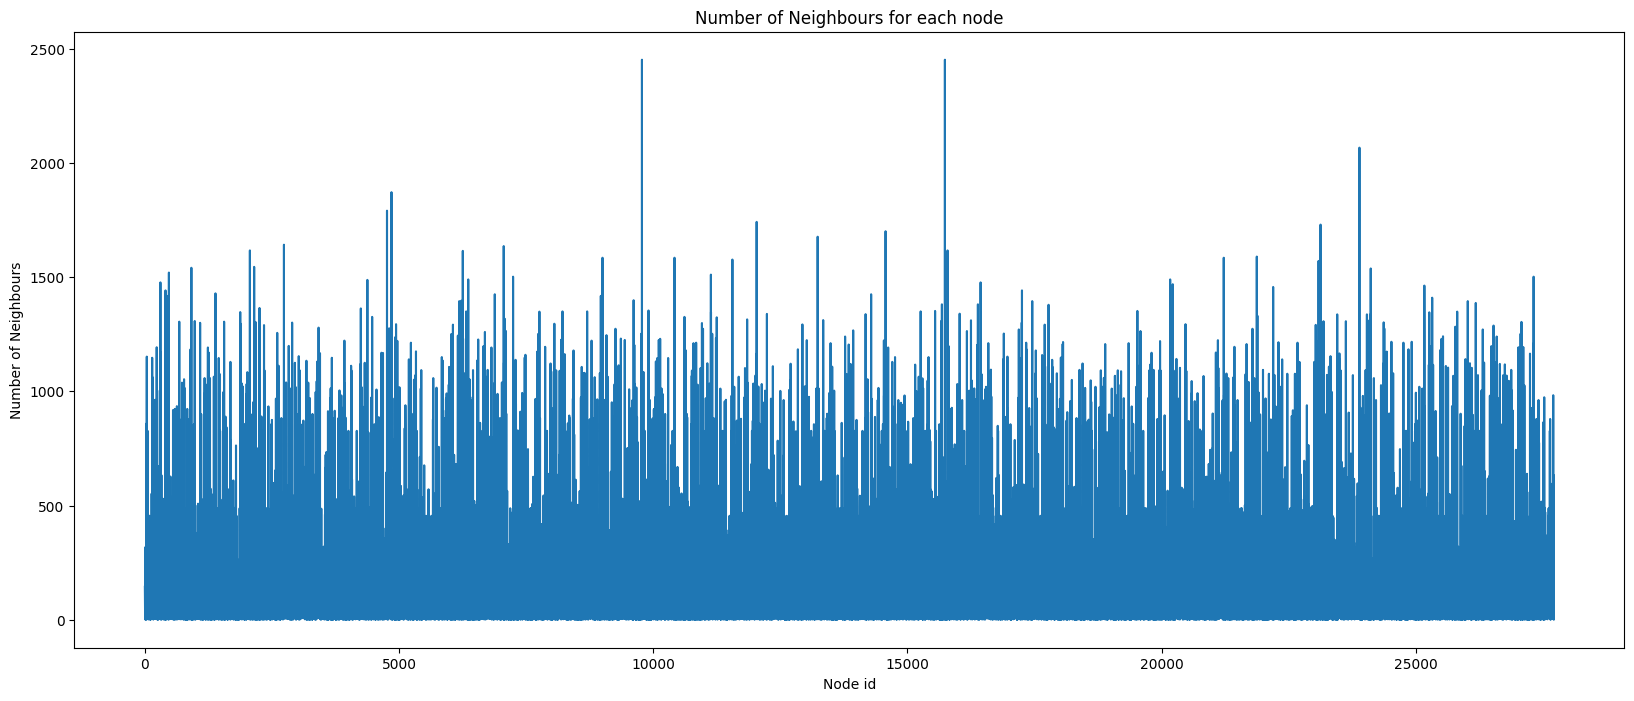

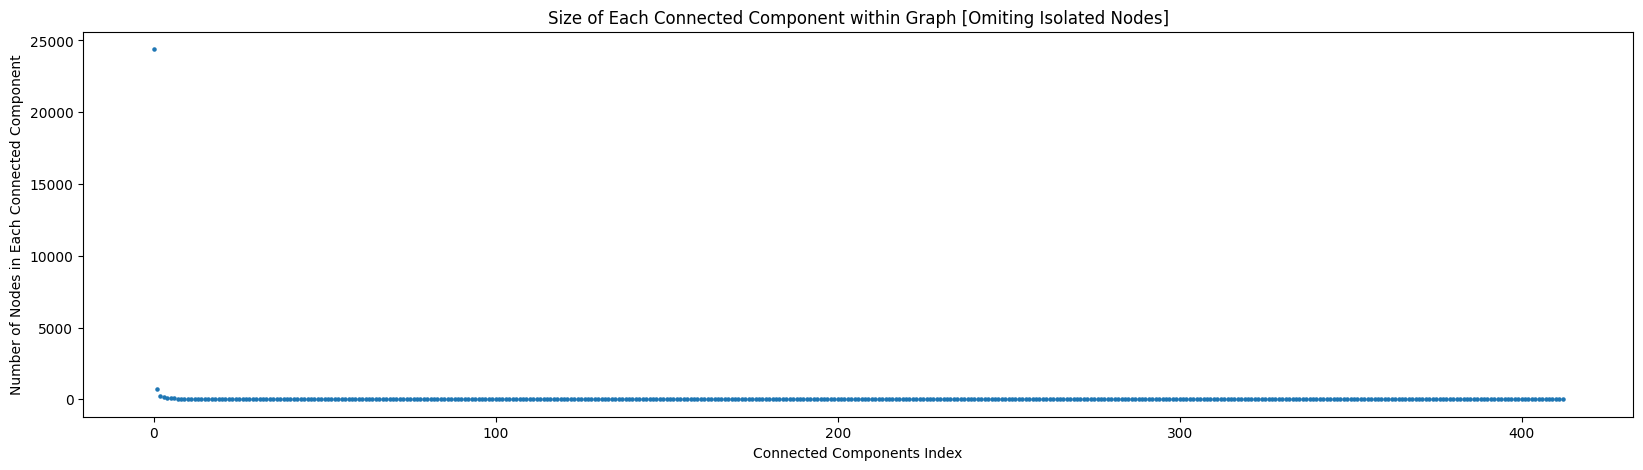

In [27]:
number_nodes = medium_graph.number_of_nodes()
number_edges = medium_graph.number_of_edges()
list_of_node = medium_graph.nodes

nodes_neigbours = []
neighbours = []
nodes_without_neighbours = []
for n in list_of_node:
    neigh = []
    for i in medium_graph.neighbors(n):
        neigh.append(i)
    if(len(neigh) == 0):
        nodes_without_neighbours.append(n)
    neighbours.append(len(neigh))    
    nodes_neigbours.append([n, len(neigh)])
    
density = nx.density(medium_graph)

connected_components = nx.number_connected_components(medium_graph)
connected_components_wo_isolation = connected_components - len(nodes_without_neighbours)

connected_components_list = list(nx.connected_components(medium_graph))
result = []

for i in range(len(connected_components_list)):
    if(len(connected_components_list[i]) > 1):
        result.append(len(connected_components_list[i]))
    
result = np.sort(result)[::-1]
indices = [i for i in range(len(result))]

print(f"1. Number of Nodes: {number_nodes}\n")
print(f"2. Number of Edges: {number_edges}\n")
print("3. Number of Neighbours of Each Node:")
print(nodes_neigbours)
print("")
print(f"4. Nodes without Neighbours: {len(nodes_without_neighbours)}")
print(nodes_without_neighbours)
print("")
print(f"5. Density of the graph is : {density}\n")
print(f"6. Number of connected components is : {connected_components}\n")
print(f"   Removing Isolated nodes the number of original graph clusters are: {connected_components_wo_isolation}\n")

print(f"7.  The first 10 larget components: {result[:10]}\n")

pyplot.figure(figsize=(20,8))
pyplot.xlabel("Node id")
pyplot.ylabel("Number of Neighbours")
pyplot.title("Number of Neighbours for each node")
pyplot.plot([i for i in range(len(neighbours))],neighbours)
pyplot.show()

pyplot.figure(figsize=(20,5))

pyplot.xlabel("Connected Components Index")
pyplot.ylabel("Number of Nodes in Each Connected Component")
pyplot.title("Size of Each Connected Component within Graph [Omiting Isolated Nodes]")
pyplot.scatter(indices,result, alpha=1.0, s = 5)
pyplot.show()

## Analysis From Familiarization:

### For Spectral Embedding:
- There are 760 connected components, of which 347 are isolated nodes (nodes without neighbors).
- Extensions and considerations we should make when constructing Spectral Embeddings:
    1. Isolated nodes will have an adverse impact on the clusterings, as in the adjacency matrix, they provide no semantic (logical) meaning. Hence, ideally, we should remove isolated nodes. However, this would cause too much overhead, and since there are only 347 isolated nodes out of 27,718, we need not consider removing them.
    2. A not fully connected graph signifies a collection of original clusters. As our graph is mostly sparse, spectral embedding will turn out to be less effective because the spectral information is more spread out across the spectrum in sparse graphs. This characteristic makes it more difficult to capture meaningful structural patterns using only a few eigenvectors. Therefore, we should use a large number of eigenvectors to better understand the data. 
In conclusion, when approaching our spectral embedding, we do not need to remove isolated nodes, as there are very few, and we should use a large number of eigenvector components when training our model.

### For Random Walks:

## 2. Spectral Node Embedding Computation
1. Calculate the Laplician Matrix
2. Eigenvectors of the Laplacian Matrix are created to generate the embeddings
3. Each row of the eigen-matrix is an embedding of its corresponsind node, since it is best not to take all the eigen componenets we create an elbow curve
4. The elbow curve shows teh information gain, since the eigenvalues are ascending we get a elbow curve must be inverted.
5. Upon analysis of the elbow curve the ideal number of componenets is around 6500
6. Computing a distance matrix to do the KNN (k nearest neighbour calculations)

## Optimizations
1. The eigenmatrix and distance matrix calculation is the most computationally expensive operation, so we decided to create a distance matrix and save it as a CSV file using 32-bit float precision to reduce memory requirements
## Extensions:
- Normalise the Laplacian by first removing isolated nodes, however for this case it will add to much overhead.

In [4]:
def embeddings(graph: nx.Graph):
    # Create adjacency matrix with 32-bit float precision
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes), dtype=np.float32)
    
    # Degree matrix (diagonal matrix with node degrees)
    degree_matrix = np.diag(adjacency_matrix.sum(axis=1)) 
    
    # Laplacian matrix: Degree matrix - Adjacency matrix
    laplacian_matrix = degree_matrix - adjacency_matrix
    
    # Eigen decomposition: Using eigh for symmetric matrices
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    return eigenvalues, eigenvectors

Calculating Embeddings

In [5]:
eigenvalues, eigenvectors = embeddings(medium_graph) 
print(eigenvalues)

[-9.9049013e-13 -9.5724589e-13 -3.1716646e-13 ...  2.0680583e+03
  2.4530000e+03  2.4531216e+03]


### Preprocessing Step
- Trying to find how many eigenvalues are negative or zero to disclude them from the embedding.
- The result is to remove the first 760

In [7]:
def count_negative_eigenvalues(eigenvalues):
    count = 0
    for value in eigenvalues:
        if value < 1e-6:
            count += 1
        else:
            break
    return count

print(f"Number of Negative Eigenvalues or Zero eigenvalues: {count_negative_eigenvalues(eigenvalues)}")

Number of Negative Eigenvalues or Zero eigenvalues: 760


### Elbow Plot to Find Dimensions
- Since small eigenvalues provide the mmore information than large eigenvalues, we decided to take the inverse and create an elbow plot.
- The elbow plot provides no semantic meaning therefor taking the second derivative will show where the increase in the information gain is the least.
- At arround the first, 6500 eigenvalues the change in information gain is the least, as seen from the second derivative. 

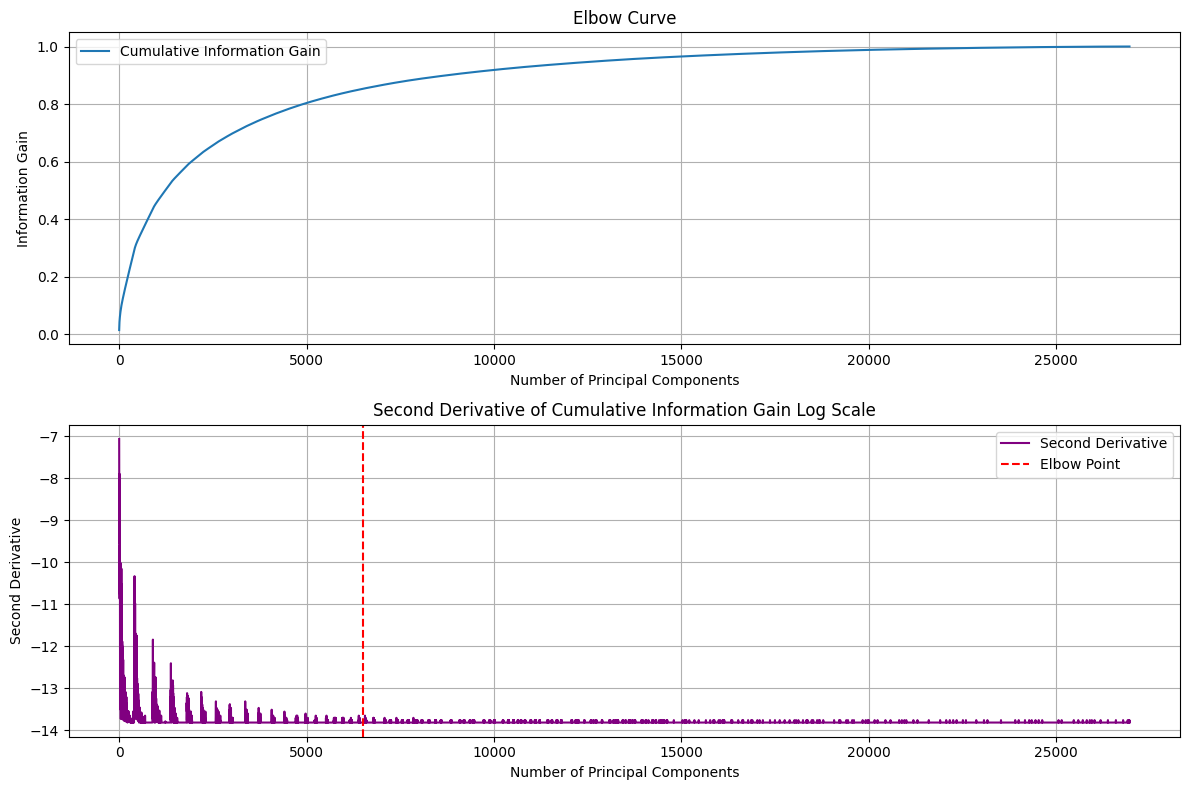

Elbow Point detected at index: 6500


In [67]:

eig_sorted = np.sort(1/eigenvalues[760:])[::-1]
explained_variance_ratio = eig_sorted / np.sum(eig_sorted)
cumulative_variance = np.cumsum(explained_variance_ratio)

second_derivative = np.diff(np.diff(cumulative_variance))
log_second_derivative = np.log(np.abs(second_derivative) + 0.000001)

dim = 6500
pyplot.figure(figsize=(12, 8))

pyplot.subplot(2, 1, 1)
pyplot.plot(cumulative_variance, label='Cumulative Information Gain')
pyplot.title("Elbow Curve")
pyplot.xlabel("Number of Principal Components")
pyplot.ylabel("Information Gain")
pyplot.legend()
pyplot.grid(True)


pyplot.subplot(2, 1, 2)
pyplot.plot(log_second_derivative, label='Second Derivative', color='purple')
pyplot.axvline(x=dim - 1, color='red', linestyle='--', label='Elbow Point')
pyplot.title("Second Derivative of Cumulative Information Gain Log Scale")
pyplot.xlabel("Number of Principal Components")
pyplot.ylabel("Second Derivative")
pyplot.legend()
pyplot.grid(True)

pyplot.tight_layout()
pyplot.show()

print(f"Elbow Point detected at index: {dim}")

### Deciding Correct Distance Metric:

There are three distance implementation that we could use:
    1. Euclidean distance
    2. Cosine distance
    3. Jaccard Similarity Distance

Considering the characteristic of our spectral data:
    - Our embedding is of 5740 dimension, computed from the eigenvectors
    - We have 27700 embeddings
    - Data is sparse

Euclidean distance is generally a poor choice for high-dimensional sparse data due to the curse of dimensionality, where most points tend to be equidistant, rendering the metric ineffective. Furthermore, it treats all dimensions equally, meaning that minor variations across irrelevant dimensions can introduce unnecessary noise. However, computation time for Euclidean distance is relatively low, as it is optimized using matrix multiplication.

Cosine distance is a better fit for high-dimensional sparse data. By measuring the angular difference between vectors, it is scale-independent and robust for scenarios where direction matters more than magnitude. However, for cosine distance to be effective, embeddings must be normalized to unit vectors. Despite its advantages, the computation time is high, as iterative methods (often requiring external libraries like scipy or sklearn) must be used to calculate the pairwise distance matrix, making it computationally expensive for datasets of this size. 

Jaccard distance is particularly useful when working with binary or set-like data. It measures similarity based on the intersection over the union of features, making it effective for sparse data. However, for continuous numerical embeddings, it is less suitable as it ignores magnitude and the overall structure of the feature space. Like cosine distance, Jaccard similarity requires iterative computation, resulting in poor performance for large datasets without specialized optimization.

Euclidean Implementation

In [9]:
def compute_distances_euclidean(matrix, location):
    squared_matrix = np.sum(matrix**2, axis=1).reshape(-1, 1)
    squared_distances = squared_matrix + squared_matrix.T - 2 * np.dot(matrix, matrix.T)
    np.fill_diagonal(squared_distances, np.inf)
    distances = np.sqrt(squared_distances)
    
    print("Saving eigenvectors to CSV...")
    pd.DataFrame(distances).to_csv(location, index=False, header=False)
    return distances

Cosine Implementation

In [82]:
from sklearn.metrics.pairwise import cosine_distances
def compute_distance_cosine(matrix, location):
    distance_matrix = cosine_distances(matrix)
    return distance_matrix

Jaccard Similarity Implementation

In [ ]:
from sklearn.metrics import pairwise_distances
distance = pairwise_distances(eigenvectors[:,760:dim], metric='jaccard')

c:\Users\satya\Documents\University\Classes\Y2\Q2_DM\DM_A2\dmenv\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [11]:
output_csv_path = "distance_matrix_2.csv"
distance = compute_distances_euclidean(eigenvectors[:,760:dim], output_csv_path)
# distance = pd.read_csv("distance_matrix_2.csv")

C:\Users\satya\AppData\Local\Temp\ipykernel_9928\3151061207.py:5: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(squared_distances)


Saving eigenvectors to CSV...


In [12]:
distance = np.array(distance)

Creating a dictionary to find the labels for the KNN classifier

In [13]:
def create_node_label_dict(csv_file_path):
    df = pd.read_csv(csv_file_path)
    node_label_dict = pd.Series(df['label'].values, index=df['node_id']).to_dict()
    
    return node_label_dict
csv_file_path = Path("data") / "train_data.csv" 
dict_labels = create_node_label_dict(csv_file_path)

In [14]:
def knn_calc(matrix, k, dict_labels):
    classification = []
    
    for i in range(len(matrix)):
        nearest_neighbors = np.argsort(matrix[i])[:k]
        label_counts = [0, 0, 0, 0]  # Software Development, AI, UX, Other
        
        for neighbor_index in nearest_neighbors:
            label = dict_labels.get(neighbor_index, 'unknown')
            
            if label == "artificial-intelligence":
                label_counts[1] += 1
            elif label == "software-development":
                label_counts[0] += 1
            elif label == "ux":
                label_counts[2] += 1
            else:
                label_counts[3] += 1
        
        npLabels = np.array(label_counts)
        
        max_index = npLabels.argmax()
        
        if max_index == 0:
            ofClass = "software-development"
        elif max_index == 1:
            ofClass = "artificial-intelligence"
        elif max_index == 2:
            ofClass = "ux"
        else:
            ofClass = "other"
        classification.append(ofClass)

    return classification


In [50]:
csv_file_path_test = Path("data") / "test_data.csv" 
dict_labels_test = create_node_label_dict(csv_file_path_test)
k_values = [10,15,20,25,26,27,28,29,30,31,32,33,34,35,37,38,42,45,47,50,55,65,75,100,200]
accuracy = []
for i in range(len(k_values)):
    print(f"Percent Done: {int(i/len(k_values)*100)}")
    c = 0
    t = 0
    result = knn_calc(distance, k_values[i], dict_labels)
    for i in range(len(result)):
        prediction = result[i]
        test = dict_labels_test.get(i)
        tOf = test == prediction
        if(test == None):
            continue
        if(test == prediction):
            c = c+1
        t = t+1
    acc = c / t
    accuracy.append(acc)

Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0
Percent Done: 0


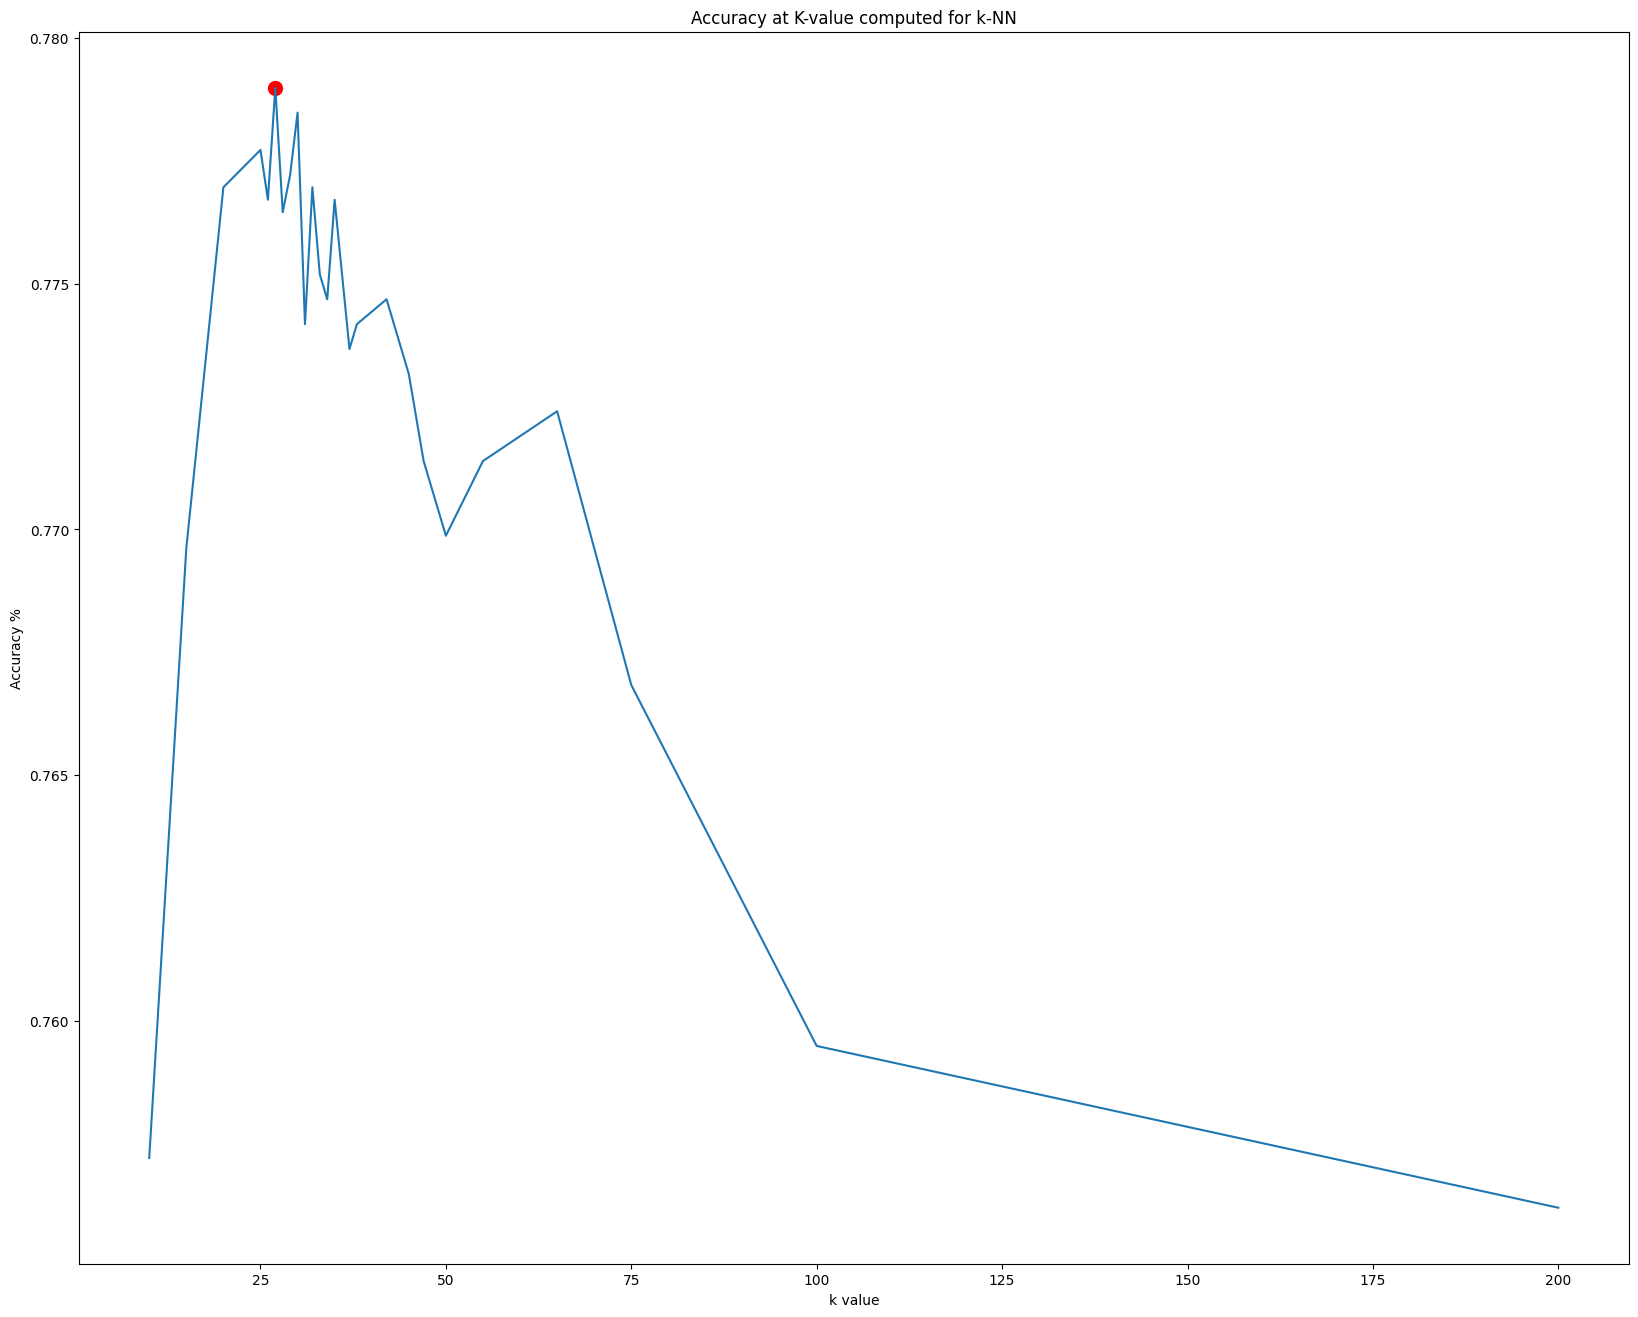

In [65]:
pyplot.figure(figsize=(20,16))
pyplot.plot(k_values,accuracy)
pyplot.ylabel("Accuracy %")
pyplot.xlabel("k value")
pyplot.title("Accuracy at K-value computed for k-NN")
pyplot.scatter(x=27,y=accuracy[5], color='red', s=100)
pyplot.show()

- Highest accuracy is 78%

In [66]:
print(f"Highest accraucy is: {round(accuracy[5]*100)} %, at k = {27}")

Highest accraucy is: 78 %, at k = 27


## 3. Word2Vec Computing Embeddings


Steps:
1. Define an econder here we will use Node2Vec
    Here we can use : DeepWalk, node2vec, TransE
2. Define a node similarity function
    Random Walk : similarity between node u and v is defined as the probability that u and v co-occur on a random walk over a network
3. Optimize the parameters of the encoder so that similarity of u anv v in the network approximate the do product between node embedding: simularity(u,v) ~ ZuT*Zv

In [9]:
# Performing Random Walk
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    result = []

    for node in graph.nodes():
        for i in range(num_walks):
            walk = [node]
            for j in range(walk_length - 1):
                current_node = walk[-1]
                neighbors_list = list(graph.neighbors(current_node))
                
                if len(neighbors_list) == 0:
                    break  # Stop walk if there are no neighbors (isolated node)
                
                # Randomly choose a neighbor
                index = np.random.randint(len(neighbors_list))
                next_node = neighbors_list[index]
                walk.append(next_node)
                
             # Pad shorter walks with None as we want to create equal length np arrays   
            if len(walk) < walk_length:
                walk.extend([None] * (walk_length - len(walk)))
            result.append(walk)

    return result


In [10]:
walks = random_walks(graph = medium_graph, num_walks= 5, walk_length = 50)

- In the Word2Vec each walk is treated like a sentence
- 

In [11]:
# walks = [list(filter(lambda x: x is not None, walk)) for walk in randomWalks] ## Removing the None values

## Each Walk is treated like a sentence
model = Word2Vec(sentences=[list(map(str, walk)) for walk in walks], vector_size=128, window=5, min_count=1, sg=0)

node_id = 0
vector = model.wv[node_id]
print(f"Vector for node {node_id}: {vector}")


Vector for node 0: [ 0.04464827  0.48899785  1.8551004   2.574473   -1.5879902  -2.1247396
 -0.33649838  2.0064492  -2.2776473  -2.5447006   1.1965591   0.38653123
  0.49140963 -0.40435892 -2.1597328   0.21571739  1.1756296  -0.07675742
 -1.9090948  -3.5822103   1.1842453   1.3795671   2.4832315   1.2993138
  1.2897567  -0.5405788   0.80309397  0.4414345  -0.5793171  -0.09252043
 -0.59640324 -1.3474857   0.84234434 -1.7660366  -0.79432887  1.4297647
  0.91126484 -1.9132389  -0.09321629 -1.2340575  -4.0022054   1.6849432
 -2.4968297  -1.3324717   1.3312261  -0.49138248 -0.82245386  3.9593341
  0.62198585  2.6255786  -3.0406625   0.17120641 -0.7756366   0.01581608
  0.8457923   0.58580405 -0.2293783  -1.5431583  -0.24572758  1.957846
 -1.5589237   1.1012049  -1.2544649  -2.2272804   1.161174   -0.40663517
  0.2607551  -1.6499565  -0.08034634 -1.5659165   0.5385303   0.7855318
 -1.3461723  -3.0407934   0.37013787 -1.618596    2.3212469   1.5086035
 -1.0348325  -1.5988256   0.25744557 -0.1